In [1]:
%run functions.py

import numpy as np
import pandas as pd
from scipy.io import loadmat

from sklearn.svm import LinearSVC
from sklearn.linear_model import Lasso,ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


# Task 2 - Regression 

## Load settings

In [2]:
pd.set_option('display.max_colwidth',-1)

k=10 # Define k for crossvalidation
seed = 42 # Seed to use
feature_tot = 0 # Total selected features -> Start at 0 before PCA

scoring='neg_mean_squared_error' # Scoring method for GridsearchCV
score_function = f_regression # Score function for Feature selection


np.random.seed(seed) # Define the random seed

In [3]:
# GridSearchCV
estimators = [
    ('clf', SVR()),
]
param_grid = [
    {
        'clf':[SVR()],
        'clf__C':[0.1,10,100],
    },{
        'clf':[Lasso(random_state=seed)],
        'clf__alpha':[0.1,1.0,2.0,5.0],

    },{
        'clf':[ElasticNet(random_state=seed)],
        'clf__alpha':[0.1,1.0,2.0,5.0],
        'clf__max_iter':[100,5000,10000],
}]

## Load dataset

In [4]:
filename = "datasets/ChemTrainNew.mat"

mat = loadmat(filename)
input_train = mat['XtrainDS']

target_train = mat['YtrainDS'].reshape(len(input_train))
input_test = mat['XtestDS']

## Data info

In [5]:
get_data_info(input_train, target_train)

Length of 4466
X.shape: (4466, 65) y.shape: (4466,)
Contains Nan: False False
Contains +inf: False False
Contains -inf: False False


## Preprocess
Normalize the dataset

In [6]:
input_train, input_test, target_train, input_train_copy, input_train_copy_normalized = preprocessing(input_train,target_train, input_test)

4466


## Feature reduction
Reduce dimensionality by PCA transform

In [7]:
feature_tot, pca, pca_input = feature_reduction(input_train, target_train,input_train_copy)

original shape:    (4466, 65)
transformed shape: (4466, 27)
Explained variance: [0.35039688 0.11184843 0.08050837 0.06509726 0.04016244 0.03188509
 0.02768326 0.02504262 0.01980678 0.01818787 0.01670203 0.01611922
 0.01469088 0.01361669 0.01296212 0.01277008 0.01182579 0.01098518
 0.01063263 0.00964813 0.00948931 0.00886604 0.00871726 0.00745555
 0.00668993 0.0063179  0.00532895]


# Plot PCA

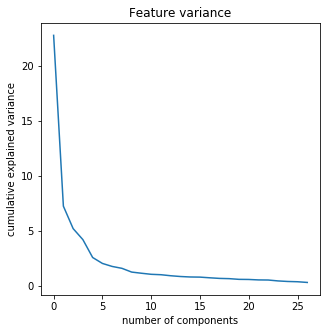

In [8]:
plot_feature_variance(pca_input)

## Plot top 10 histogram over reduced features

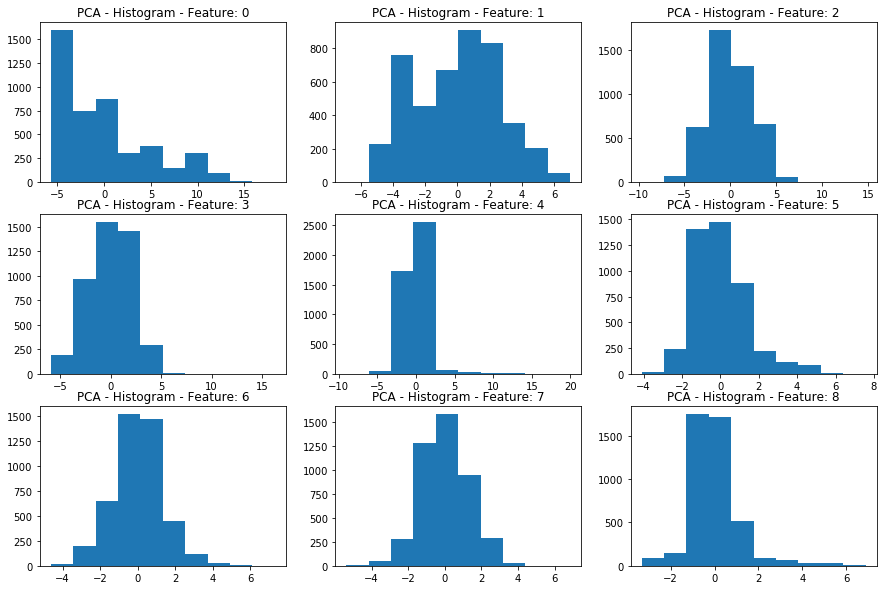

In [9]:
plot_top_features(feature_tot,pca_input)

# Feature selection
Extract top features above depending on PCA

(4466, 65)


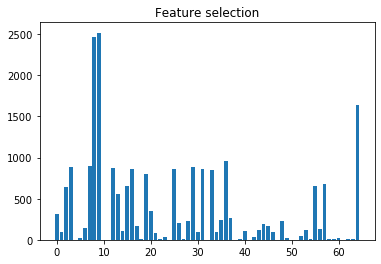

In [10]:
input_train_fs, input_test_fs = feature_selection(score_function, input_train, target_train, input_test, feature_tot=feature_tot)

## Hyperparameter tuning

In [11]:
# GridSearchCV
grid = parameter_tuning(estimators, param_grid, scoring, input_train_fs, target_train, k)


## Get Model info

In [12]:
get_model_info(grid)

Best score: -78.86442223935714
Best params {'clf': SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False), 'clf__C': 10}


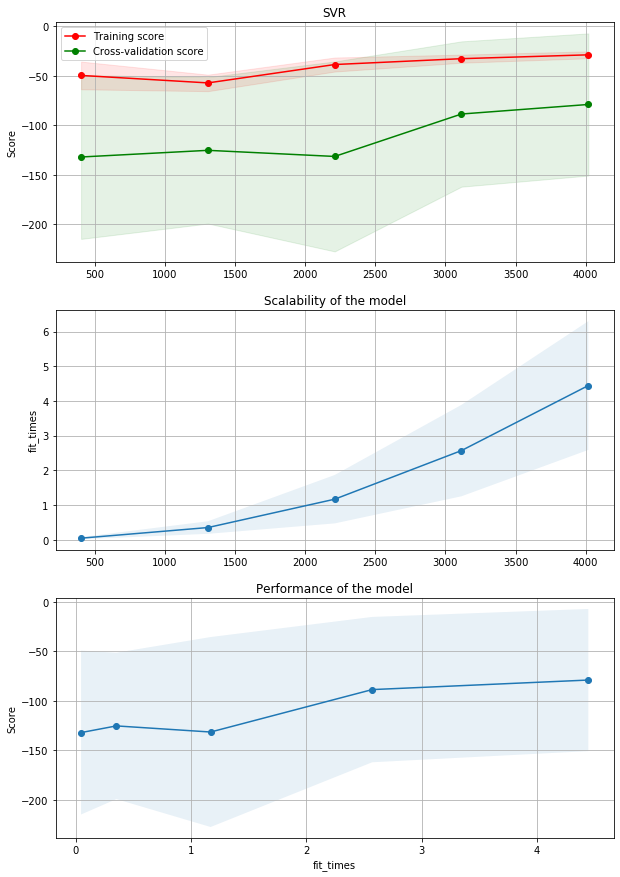

In [13]:
validate_curve(grid, input_train_fs, target_train,scoring=scoring, k=k)

# Predict testset

In [14]:
model = predict_model(grid, input_train_fs, target_train, input_test_fs)

[64.88659447 64.94573034 63.54742857 ... 58.45371585 58.46915176
 56.52017334]
